# Word Embeddings

Data from: https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks

## Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
df = pd.read_csv('books.csv', on_bad_lines='skip')
df = df.reset_index(drop=True)
df.authors = [i.split('/')[0] for i in df.authors]
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## Word Cloud

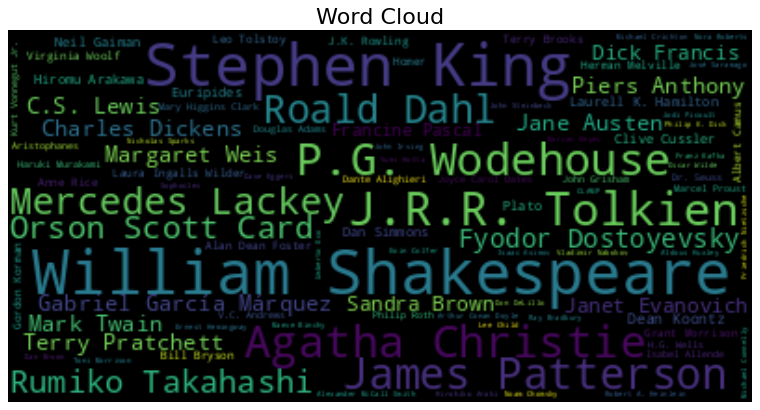

In [3]:
from wordcloud import WordCloud

d = {}
for x, a in zip(df.authors.value_counts(), df.authors.value_counts().index):
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud", fontsize=20)
plt.savefig("cloud.png", dpi=200)
plt.show()

## Word Embedding

In [4]:
df = df.drop_duplicates('authors')
df = df.reset_index(drop=True)
df = df[:30]
size = len(df.authors)
# Considering the whole dataset as training set to perform labeling and
# scaling, since we are just interested in creating the embeddings
# but no further predictions are going to be performed
encoder, scaler = LabelEncoder(), MinMaxScaler()
aut = encoder.fit_transform(df.authors) 
rat = scaler.fit_transform(df[['average_rating']])

In [5]:
class Latent_Embed(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Latent_Embed, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(3, 2)
        self.linear2 = nn.Linear(2, 1)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        return out


aut_t = torch.tensor(aut)
rat_t = torch.tensor(rat)
loss_function = nn.MSELoss()
model = Latent_Embed(size, 3)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(10):
    total_loss = 0
    for context, target in zip(aut_t, rat_t):
        model.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs.double(), target.view(1).double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Loss: ", total_loss/len(aut_t))

Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945
Loss:  0.35237252487945


In [6]:
embedding_weights = pd.DataFrame(model.embeddings.weight.detach().numpy())
embedding_weights.columns = ['X1','X2','X3']
embedding_weights

,X1,X2,X3
0,0.028842,-0.160257,-2.030848
1,-0.563354,-1.283095,-0.177623
2,1.412609,0.658555,-1.146619
3,0.903076,-0.474520,0.869346
4,0.681715,1.210547,0.257247
5,2.205737,-0.194147,-1.437747
6,-2.554840,-1.388558,2.309654
7,-1.186686,-2.258626,-0.256457
8,-0.567041,1.462722,-1.295464
9,0.119296,0.149326,-0.501014


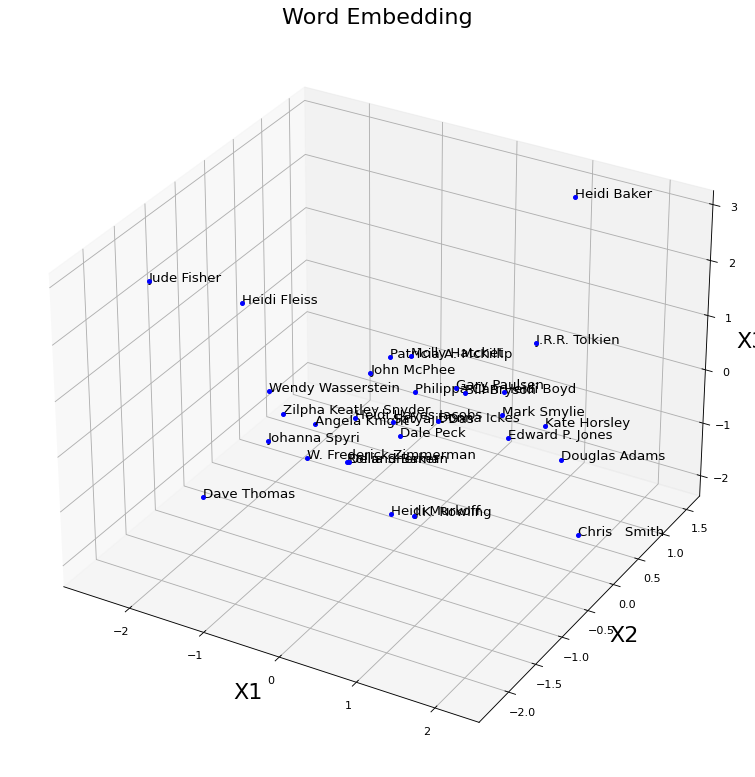

In [7]:
fig = plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection='3d')
for index, (x, y, z) in enumerate(zip(embedding_weights['X1'], 
                                      embedding_weights['X2'], 
                                      embedding_weights['X3'])):
    ax.scatter(x, y, z, color='b', s=12)
    ax.text(x, y, z, str(df.authors[index]), size=12, zorder=2.5, color='k')

ax.set_title("Word Embedding", fontsize=20)
ax.set_xlabel("X1", fontsize=20)
ax.set_ylabel("X2", fontsize=20)
ax.set_zlabel("X3", fontsize=20)
plt.show()

In [8]:
def rotate(angle):
    ax.view_init(azim=angle)

print("Making animation")
res_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 365, 2), interval=100)
res_animation.save('embedding.gif', dpi=100, writer='imagemagick')

Making animation


Exercises:

1. Are you able to create an interactive progress bar for the word embedding training process? [tqdm](https://tqdm.github.io/), could be of your help.
2. Can you also create a live plot tracking the training loss of the embedding model? [livelossplot](https://p.migdal.pl/livelossplot/), could be of your help as well as other tools such as [Tensorboard](https://www.tensorflow.org/tensorboard).